# Importing the libraries

In [51]:
#Make sure that you have all the libraries installed

import numpy as np
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math

# Reading the data

In [52]:
urlConfirmed='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
COVID19Series = pd.read_csv(urlConfirmed)

urlDeaths='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
COVID19Deaths= pd.read_csv(urlDeaths)

#Setting to display all contents
pd.set_option('display.max_rows', len(COVID19Series) + 1)
pd.set_option('display.max_columns', len(COVID19Series.columns) + 1)

In [53]:
print('Last update:',COVID19Series.columns[-1])

Last update: 3/27/20


# Testing to see if the data has been read

In [54]:
COVID19Series.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4


In [55]:
COVID19Deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,4,4
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,4,5,5,6,8
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,4,4,4,7,9,11,15,17,17,19,21,25,26
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Setting some countries to use the data

In [56]:
Country=COVID19Series['Country/Region']

# Making the graphics 

In [57]:
#Setting some different markers to use in the plots
markerList=['.','d','s','v','^','+','x','8','>','<','*']

#Setting countries to use
CountryNames=['Brazil','Italy','United Kingdom','Germany','France','Korea, South','US','Luxembourg','Spain','China']

# Bar plot

Country: Confimed Cases, total deaths (deaths/confirmed), new deaths

Brazil : 3417, 92 (0.03), 15
Italy : 86498, 9134 (0.11), 919
United Kingdom : 14745, 761 (0.05), 181
Germany : 50871, 342 (0.01), 75
France : 33402, 1997 (0.06), 299
Korea, South : 9332, 139 (0.01), 8
US : 101657, 1581 (0.02), 372
Luxembourg : 1605, 15 (0.01), 6
Spain : 65719, 5138 (0.08), 773
China : 81897, 3296 (0.04), 5


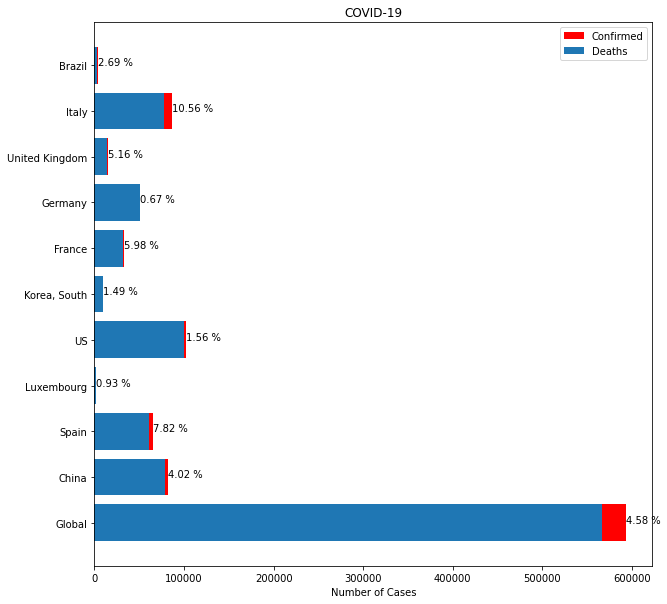

In [59]:
confirmed=[]
deaths=[]

CountryList=CountryNames


print("Country: Confimed Cases, total deaths (deaths/confirmed), new deaths\n")
for i in range(len(CountryNames)):
    c = COVID19Series[Country==CountryNames[i]].iloc[:,-1].sum()
    confirmed = np.append(confirmed,c)
    d = COVID19Deaths[Country==CountryNames[i]].iloc[:,-1].sum()
    deaths = np.append(deaths,d)
    newdeaths = d - COVID19Deaths[Country==CountryNames[i]].iloc[:,-2].sum()
    r=d/c
    print(CountryNames[i],': %.0f, %.0f (%.2f), %.0f' % (c,d,r,newdeaths))

confirmed = np.append(confirmed,COVID19Series.iloc[:,-1].sum())
deaths = np.append(deaths,COVID19Deaths.iloc[:,-1].sum())


CountryNames.append('Global')

y_pos = np.arange(len(confirmed))
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.barh(y_pos,confirmed, color='r')
ax.barh(y_pos,confirmed-deaths)
ax.legend(labels=['Confirmed', 'Deaths'])
ax.set_yticks(y_pos)
ax.set_yticklabels(CountryNames)
ax.invert_yaxis()

ax.set_xlabel('Number of Cases')
ax.set_title('COVID-19')

for i, (value, name) in enumerate(zip(deaths, CountryNames)):
    ax.text(confirmed[i], i, '%.2f %%' % (deaths[i]/confirmed[i]*100), ha='left')
    
CountryNames.remove('Global')

# Confirmed cases along the days 

Increase or decrease:
Brazil 0.14
Italy 0.07
United Kingdom 0.25
Germany 0.16
France 0.13
Korea, South 0.01
US 0.21
Luxembourg 0.10
Spain 0.14
China 0.00


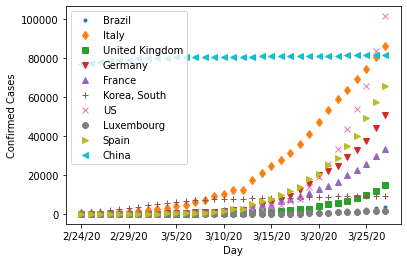

In [9]:
print("Increase or decrease:")
for i in range(len(CountryNames)):
    
    #Shows if the cases has increse or decrease from the last day
    print(CountryNames[i]+' %0.2f' % ((COVID19Series[Country==CountryNames[i]].iloc[:,-1].sum()-COVID19Series[Country==CountryNames[i]].iloc[:,-2].sum())/COVID19Series[Country==CountryNames[i]].iloc[:,-2].sum()))
    
    #plot the curve of the confirmed cases along the days
    country = COVID19Series[Country==CountryNames[i]].iloc[:,37:].sum()
    country.plot(marker=markerList[i], label=CountryNames[i], ls='none')
    
plt.xlabel('Day')
plt.ylabel('Confirmed Cases')
plt.legend()

#Save the plot in a png format
#plt.savefig('ConfirmedCases.png', dpi=300)
plt.show()


# Confirmed cases since the first record in the country

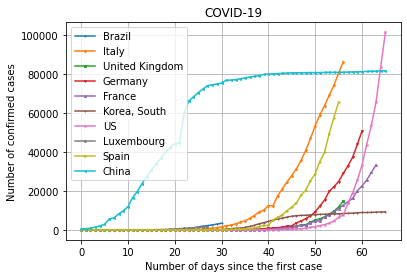

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for i in range(len(CountryNames)):
    country = COVID19Series[Country==CountryNames[i]].iloc[:,4:].sum()
    temp = np.array(country.values)
    
    #Set the number of cases to 1
    y_filter = np.where(temp > 0)
    y = temp[y_filter]
    x = np.arange(len(y))
    ax.plot(x, y, marker=markerList[i], markersize=2, ls='-', label=CountryNames[i])


plt.xlabel('Number of days since the first case')
plt.ylabel('Number of confirmed cases')
plt.title('COVID-19')
plt.legend()
plt.grid()
#plt.savefig('ConfirmedSinceFirstCase.png', dpi=300)

# Confirmed cases since of the 100 first records in the country

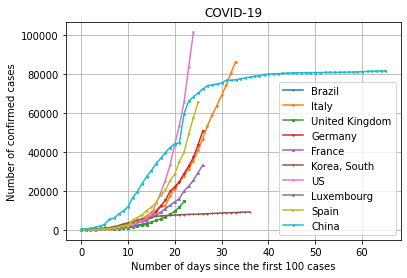

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
#x = np.arange(len(China.iloc[:,4:].sum()))
for i in range(len(CountryNames)):
    country = COVID19Series[Country==CountryNames[i]].iloc[:,4:].sum()
    temp = np.array(country.values)
    
    #Set the number of cases to 100
    y_filter = np.where(temp > 100)
    y = temp[y_filter]
    x = np.arange(len(y))
    ax.plot(x, y, marker=markerList[i], markersize=2, ls='-', label=CountryNames[i])


plt.xlabel('Number of days since the first 100 cases')
plt.ylabel('Number of confirmed cases')
plt.title('COVID-19')
plt.legend()
plt.grid()
#plt.savefig('ConfirmedSince100Cases.png', dpi=300)

# Number of deaths since the first record

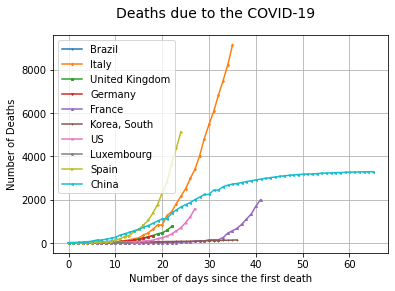

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
#x = np.arange(len(China.iloc[:,4:].sum()))
for i in range(len(CountryNames)):
    country = COVID19Deaths[Country==CountryNames[i]].iloc[:,4:].sum()
    temp = np.array(country.values)
    
    #Set the first record
    y_filter = np.where(temp > 0)
    y = temp[y_filter]
    x = np.arange(len(y))
    ax.plot(x, y, marker=markerList[i], markersize=2,ls='-', label=CountryNames[i])

fig.suptitle("Deaths due to the COVID-19", fontsize=14)
ax.set(xlabel='Number of days since the first death')
ax.set(ylabel='Number of Deaths')

ax.legend()
ax.grid()

#plt.savefig('Deaths.png', dpi=300)

#  Number of deaths since the first record and Logscale

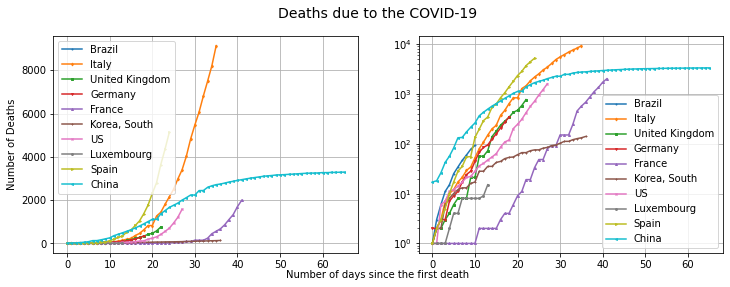

In [13]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 4))
#x = np.arange(len(China.iloc[:,4:].sum()))
for i in range(len(CountryNames)):
    country = COVID19Deaths[Country==CountryNames[i]].iloc[:,4:].sum()
    temp = np.array(country.values)
    y_filter = np.where(temp > 0)
    y = temp[y_filter]
    x = np.arange(len(y))
    ax1.plot(x, y, marker=markerList[i], markersize=2,ls='-', label=CountryNames[i])
    ax2.plot(x, y, marker=markerList[i], markersize=2,ls='-', label=CountryNames[i])
    plt.yscale('log')

    
fig.text(0.5, 0.04, 'Number of days since the first death', ha='center')
fig.suptitle("Deaths due to the COVID-19", fontsize=14)
ax1.set(ylabel='Number of Deaths')
ax1.legend()
ax1.grid()
ax2.legend()
ax2.grid()
#plt.savefig('Deaths.png', dpi=300)

# Defining an exponential function to fit the data

In [14]:
def exponenial_func(x, a, b,c):
    return a*np.exp(b*x) + c

# Fitting the data for China, Italy and Brazil

fit 0.152299
fit 0.294454
fit 0.280426


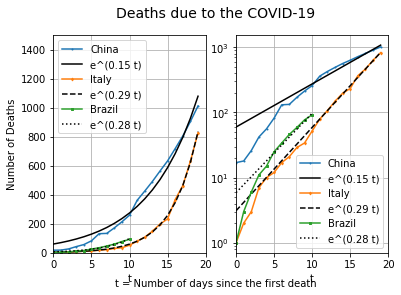

In [15]:
ls=['-','--',':']
NewCountryNames=['China','Italy','Brazil']

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(6, 4))

for i in range(len(NewCountryNames)):
    country = COVID19Deaths[Country==NewCountryNames[i]].iloc[:,4:].sum()
    temp = np.array(country.values)
    y_filter = np.where(temp > 0)
    y = temp[y_filter]
    x = np.arange(len(y))
    
    #taking only the first 20 days
    D=20
   
    xx=x[:D]
    y_=y[:D]
    popt, pcov = curve_fit(exponenial_func, xx, y_, p0=(1, 1, 0), bounds=(0,[np.inf, 2, np.inf]))
    print('fit %f' % popt[1])
    ax1.plot(xx, y_, marker=markerList[i], markersize=2, ls='-', label=NewCountryNames[i])
    ax2.plot(xx, y_, marker=markerList[i], markersize=2, ls='-', label=NewCountryNames[i])
    yy = exponenial_func(xx, *popt)
    ax1.plot(xx,yy, ls=ls[i], label=('e^(%.2f t)'%popt[1]), color='black')
    ax2.plot(xx,yy, ls=ls[i], label=('e^(%.2f t)'%popt[1]), color='black')
    plt.yscale('log')

fig.text(0.5, 0.01, 't = Number of days since the first death', ha='center')
fig.suptitle("Deaths due to the COVID-19", fontsize=14)
ax1.set_xlim([0, D])
ax1.set_ylim([0,1500])
ax1.set(ylabel='Number of Deaths')
ax1.set(xlabel='t')
ax1.legend()
ax1.grid()

ax2.set(xlabel='t')
ax2.set_xlim([0, D])
ax2.legend()
ax2.grid()
#plt.savefig('DeathsFit.png', dpi=300)

# Prediction of deaths in Brazil

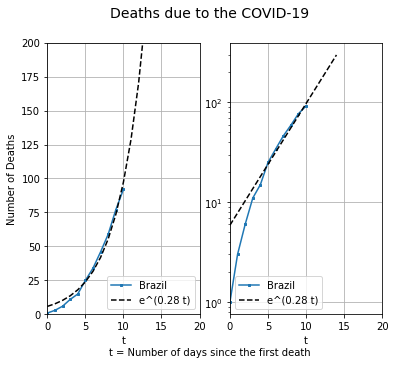

In [16]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(6, 5))

#taking only the first 20 days
D=20

country = COVID19Deaths[Country=='Brazil'].iloc[:,4:].sum()
temp = np.array(country.values)
y_filter = np.where(temp > 0)
y = temp[y_filter]
x = np.arange(len(y))

ax1.plot(x, y, marker=markerList[i], markersize=2, ls='-', label='Brazil')
ax2.plot(x, y, marker=markerList[i], markersize=2, ls='-', label='Brazil')

popt, pcov = curve_fit(exponenial_func, x, y, p0=(1, 1, 0), bounds=(0,[np.inf, 2, np.inf]))

xx= np.append(x,[x[-1]+1,x[-1]+2,x[-1]+3,x[-1]+4])
yy = exponenial_func(xx, *popt)

ax1.plot(xx,yy, ls='--', label=('e^(%.2f t)'%popt[1]), color='black')
ax2.plot(xx,yy, ls='--', label=('e^(%.2f t)'%popt[1]), color='black')
plt.yscale('log')

fig.text(0.5, 0.01, 't = Number of days since the first death', ha='center')
fig.suptitle("Deaths due to the COVID-19", fontsize=14)

ax1.set_xlim([0, D])
ax1.set_ylim([0,200])
ax1.set(ylabel='Number of Deaths')
ax1.set(xlabel='t')
ax1.legend()
ax1.grid()

ax2.set(xlabel='t')
ax2.set_xlim([0, D])
ax2.legend()
ax2.grid()
#plt.savefig('BrazilFit.png', dpi=300)


Brazil fit 0.280426
time to double the deaths: 2 days 11.3h
Number of deads today: 92 | Tomorrow: 129| New in a day 37


Italy fit 0.294454
time to double the deaths: 2 days 8.5h

Spain fit 0.269774
time to double the deaths: 2 days 13.7h

United Kingdom fit 0.256722
time to double the deaths: 2 days 16.8h

US fit 0.269653
time to double the deaths: 2 days 13.7h


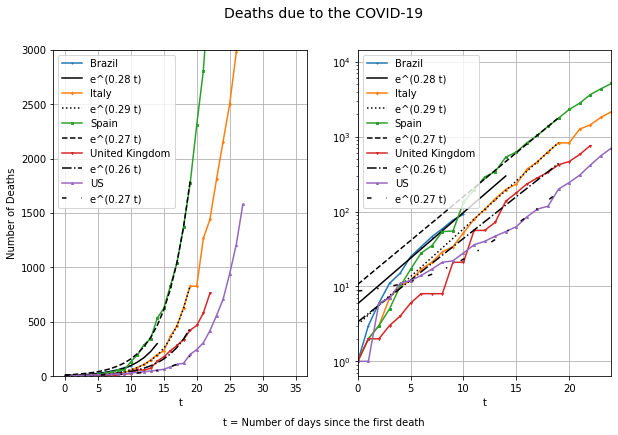

In [28]:
ls=['-',':','--','-.',(0, (3, 10, 1, 10))]
NewCountryNames=['Brazil','Italy','Spain','United Kingdom','US']

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 6))

for i in range(len(NewCountryNames)):
    country = COVID19Deaths[Country==NewCountryNames[i]].iloc[:,4:].sum()
    temp = np.array(country.values)
    y_filter = np.where(temp > 0)
    y = temp[y_filter]
    x = np.arange(len(y))
    
    #taking only the first D days
    D=20
   
    xx=x[:D]
    yy=y[:D]
    popt, pcov = curve_fit(exponenial_func, xx, yy, p0=(1, 1, 0), bounds=(0,[np.inf, 2, np.inf]))
    
    ax1.plot(x, y, marker=markerList[i], markersize=2, ls='-', label=NewCountryNames[i])
    ax2.plot(x, y, marker=markerList[i], markersize=2, ls='-', label=NewCountryNames[i])
    
    
   
    #prediction to double the numbers of dead
    days = math.log(2)/popt[1]
    hours = (days - int(days))*24
    print('\n'+NewCountryNames[i]+' fit %f\ntime to double the deaths: %d days %.1fh' 
          % (popt[1], int(days), hours))

    if (x[-1] <= D) :
         #Prediction for the next 4 days
        xx= np.append(x,[x[-1]+1,x[-1]+2,x[-1]+3,x[-1]+4])
        y_ = exponenial_func(xx, *popt)
        print('Number of deads today: %.0f | Tomorrow: %.0f| New in a day %.0f\n'% (COVID19Deaths[Country==NewCountryNames[i]].iloc[:,-1].sum(),y_[-4],y_[-4]-COVID19Deaths[Country==NewCountryNames[i]].iloc[:,-1].sum()))
        ax1.plot(xx,y_, ls=ls[i], label=('e^(%.2f t)'%popt[1]), color='black')
        ax2.plot(xx,y_, ls=ls[i], label=('e^(%.2f t)'%popt[1]), color='black')
        plt.yscale('log')
    else:
        y_ = exponenial_func(xx, *popt)
        ax1.plot(xx,y_, ls=ls[i], label=('e^(%.2f t)'%popt[1]), color='black')
        ax2.plot(xx,y_, ls=ls[i], label=('e^(%.2f t)'%popt[1]), color='black')
    

fig.text(0.5, 0.01, 't = Number of days since the first death', ha='center')
fig.suptitle("Deaths due to the COVID-19", fontsize=14)

ax1.set(xlabel='t\n')
#ax1.set_xlim([0, D+4])
#ax1.set_xticks(np.arange(0, D+5, 5))
ax1.set_ylim([0,3000])
ax1.set(ylabel='Number of Deaths')
ax1.legend()
ax1.grid()

ax2.set(xlabel='t\n')
ax2.set_xticks(np.arange(0, D+5, 5))
ax2.set_xlim([0, D+4])
ax2.legend()
ax2.grid()

